# A2: Image classification in the brower

In this assignment, you will gain real-world experience with image classification on small datasets - a common scenario in practice. There are three parts.

1. First, you will train a model on a small existing dataset.

2. Next,  you will collect a small dataset yourself. Of course, in practice there isn’t often a dataset available for tasks you care about, so it’s valuable to get a feel for this process. You will train a small model from scratch, then use data augmentation to improve accuracy.

3. Finally, you will deploy your model from part two in a webpage using TensorFlow.js. A user will be able to upload a photo, and your model will classify it.

## Instructions

Please complete this notebook by searching for **"TODO"**.

## Submission instructions

Please submit this assignment on CourseWorks by uploading a Jupyter notebook that includes saved output. If you are working in Colab, you can prepare your notebook for submission by ensuring that runs end-to-end, then saving and downloading it:

1. ```Runtime -> Restart and run all```
1. ```File -> Save```
1. ```File -> Download.ipynb```

Note: you will need to include a URL to your webpage for part 3, see the final TODO at the bottom of this notebook.

## Setup instructions
1. If you are running this notebook in Colab, make sure a GPU is enabled (```Edit -> Notebook settings -> Hardware accelerator```).

2. Create a GitHub Pages repo by following the instructions at https://pages.github.com/. You may use this to host your webpage.

In [4]:
try:
  %tensorflow_version 2.x # enable TF 2.x in Colab
except Exception:
  pass

In [5]:
import tensorflow as tf
print(tf.__version__)

2.0.0


## 1a) Flowers

In this part of the assignment, you will train a model on a small existing dataset (flowers).

In [6]:
import IPython.display as display
import matplotlib.pyplot as plt
import random
import time

from tensorflow.keras import datasets, layers, models

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 192
SHUFFLE_SIZE = 1000

### Download the flowers dataset

In [3]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

228818944/228813984 [==============================] - 16s 0us/step
/Users/Muf/.keras/datasets/flower_photos


### Write an input pipeline from scratch
There are several ways to load images in TensorFlow. Later in this assignment, you'll use the [Keras preprocessing utilities](https://keras.io/preprocessing/image/). For starters, though, you'll write your own using ```tf.data```, based on this [tutorial](https://www.tensorflow.org/beta/tutorials/load_data/images). This is valuable to do once (just so you can see how the nuts and bolts work) before using the higher level utils. A bunch of the code is written for you, there are only a couple of TODOs. Follow along, though, and try to understand each piece.


In [7]:
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [8]:
all_image_paths[:5]

['/Users/Muf/.keras/datasets/flower_photos/roses/6039330368_c30ed224c4_m.jpg',
 '/Users/Muf/.keras/datasets/flower_photos/roses/921138131_9e1393eb2b_m.jpg',
 '/Users/Muf/.keras/datasets/flower_photos/dandelion/7132605107_f5e033d725_n.jpg',
 '/Users/Muf/.keras/datasets/flower_photos/tulips/4590702749_e1df8e0c1b.jpg',
 '/Users/Muf/.keras/datasets/flower_photos/tulips/164578909_51f245d3fa_n.jpg']

### Get to know your data

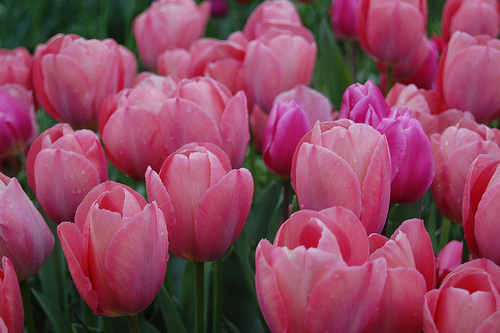

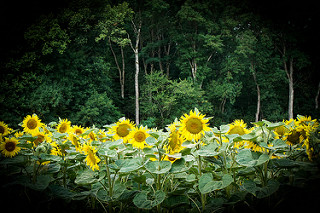

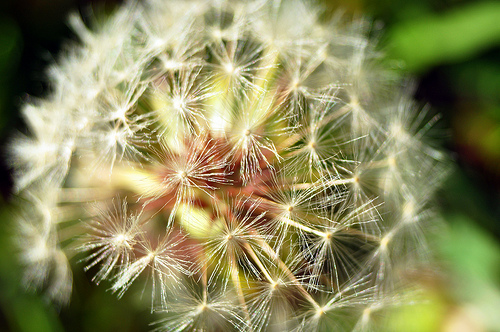

In [9]:
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print()

### Classes are given by directory names

In [10]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [11]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [12]:
all_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_labels[:10])

First 10 labels indices:  [2, 2, 1, 4, 4, 1, 4, 2, 3, 0]


### Create a train/test split

In [27]:
from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(all_image_paths, all_labels)   

### Display a few images and their labels

tulips


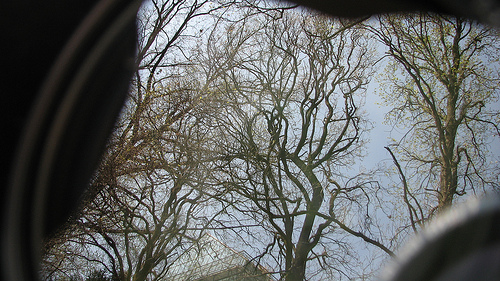


sunflowers


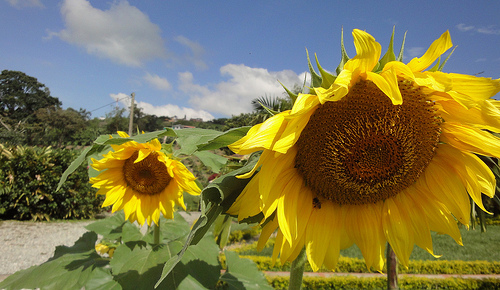


roses


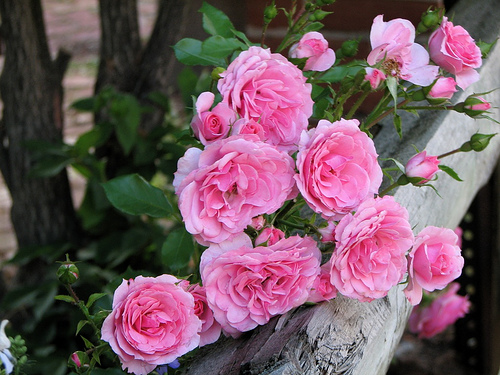

In [37]:
for n in range(3):
  i = random.randint(0,len(train_paths))
  image_path = train_paths[i]
  print(label_names[train_labels[i]])
  display.display(display.Image(image_path))
  print()

### Begin using TensorFlow ops to read and decode the images

In [38]:
img_raw = tf.io.read_file(train_paths[0])
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=96, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\...


In [39]:
img_tensor = tf.image.decode_image(img_raw)
print(img_tensor.shape)
print(img_tensor.dtype)

(273, 320, 3)
<dtype: 'uint8'>


In [40]:
img_final = tf.image.resize(img_tensor, [IMG_SIZE, IMG_SIZE])
img_final = img_final / 255.0 # normalize pixel values
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
1.0


### Wrap those in a function
Tip: pay careful attention to the preprocessing. When you deploy models in the browser, you will need to ensure that images are preprocessed identically in JavaScript as they are in Python.

In [41]:
def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  img /= 255.0  # normalize to [0,1] range
  return img

In [42]:
def show(img, label):
  plt.imshow(img)
  plt.title(label)
  plt.xticks([])
  plt.yticks([])
  print()

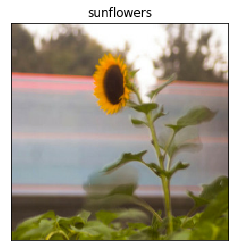

In [43]:
img_path = train_paths[0]
img = load_and_preprocess_image(img_path)
label = label_names[train_labels[0]]
show(img, label)

### Build an input pipeline to return images and labels
I realize this is complicated. The problem we're trying to solve using tf.data is performance (we want our preprocessing to run in C, but to write our code in Python). There are a bunch of advanced tricks you can do with tf.data as well (e.g. prefetching images to the GPU).

Note: although your *peak* performance can be higher, it's also very easy to make mistakes and end up with code that's super slow. Always benchmark your input pipelines before using them (shown in a bit). 

In [44]:
# a dataset that returns image paths
path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
for n, img_path in enumerate(path_ds.take(4)):
  print(n, img_path)

0 tf.Tensor(b'/Users/Muf/.keras/datasets/flower_photos/sunflowers/15054864058_2edca122a9_n.jpg', shape=(), dtype=string)
1 tf.Tensor(b'/Users/Muf/.keras/datasets/flower_photos/tulips/164578909_51f245d3fa_n.jpg', shape=(), dtype=string)
2 tf.Tensor(b'/Users/Muf/.keras/datasets/flower_photos/sunflowers/3749091071_c146b33c74_n.jpg', shape=(), dtype=string)
3 tf.Tensor(b'/Users/Muf/.keras/datasets/flower_photos/roses/8209458141_38f38be65c_m.jpg', shape=(), dtype=string)


In [45]:
# a dataset that returns images (loaded off disk, decoded, and preprocessed)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
for n, image in enumerate(image_ds.take(4)):
  print(n, image.shape)

0 (192, 192, 3)
1 (192, 192, 3)
2 (192, 192, 3)
3 (192, 192, 3)


In [46]:
# a dataset that returns labels
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.int64))
for label in label_ds.take(4):
  print(label_names[label.numpy()])

sunflowers
tulips
sunflowers
roses


In [47]:
# a dataset that returns images and labels
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [48]:
for img, label in image_label_ds.take(2):
  print(img.shape, label_names[label.numpy()])

(192, 192, 3) sunflowers
(192, 192, 3) tulips


### Batch and shuffle
Why do we need to specify a shuffle_size parameter? tf.data works with streams (it doesn't know their length). To shuffle items, we maintain an in-memory buffer of this size.

In [49]:
ds = image_label_ds.shuffle(SHUFFLE_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

for img, label in ds.take(2):
  print(img.shape, label.shape) # notice it's returning batches of data now

(32, 192, 192, 3) (32,)
(32, 192, 192, 3) (32,)


At this point, you could use the dataset above to train a model with ```model.fit(ds)``` but first, let's improve performance. As written, the dataset will load each image off disk, one at a time (super slow). Instead, we want to cache them in memory.

### Improve performance

In [50]:
# A benchmark utility to time how long it takes
# to iterate once over the entire dataset
def time_one_epoch(ds):
  start = time.time()
  batches = 0
  for i,(images,labels) in enumerate(ds):
    batches += 1
    if i % 10 == 0:
      print('.', end='')
  print()
  end = time.time()
  duration = end-start
  print("Read {} batches".format(batches))
  print("{:0.2f} Batches/s".format(batches/duration))
  print("{:0.2f} Images/s".format(BATCH_SIZE*batches/duration))
  print("Total time: {}s".format(duration))

### Use in-memory caching
This is a small dataset, so let's keep it in memory. The first time we iterate over this dataset, images will be loaded off disk, then cached. The first iteration will be quite slow, and subsequent ones will be faster. Let's show that. 

In [51]:
ds = image_label_ds.cache() # cache data in mempry
ds = ds.shuffle(SHUFFLE_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [52]:
time_one_epoch(ds) # this will be slow

.........
Read 86 batches
6.01 Batches/s
192.25 Images/s
Total time: 14.3146071434021s


Now that the cache is built, iteration will be much faster.

In [53]:
time_one_epoch(ds) # this will be fast

.........
Read 86 batches
125.96 Batches/s
4030.59 Images/s
Total time: 0.68277907371521s


If the dataset did not fit into memory, you could use a cache file on disk, like this:

```
ds = image_label_ds.cache(filename='./cache.tf-data')
ds = ds.shuffle(buffer_size=BUFFER_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
```

This can be useful to perform expensive preprocessing only once, and/or to improve file I/O (TF saves the cache file in an efficient format - it can be faster to read one large file than a bunch of small ones).

In [31]:
# here's our final training dataset
train_ds = image_label_ds.cache()
train_ds = train_ds.shuffle(SHUFFLE_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# let's make a test dataset as well
path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
test_ds = image_label_ds.cache().batch(BATCH_SIZE)

### Finally, we have a fast pipeline ready to go, written from scratch
Now, let's define a model.

## 1b) Create a simple CNN

In [34]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D())
### TODO: your code here
# Add another pair of Conv2d and MaxPoolin2dD layers
# As the depth of the network increases, the images
# become smaller, and you can afford to use more 
# filters in each layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 190, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 93, 93, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 64)        0         
Total params: 19,392
Trainable params: 19,392
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))

### Tip: pay attention to the size of the model
Later, when you export a model to run in the webpage, you will want a small one (in terms of the number of parameters) that downloads quickly. Notice how much more efficient the convolutional layers are than the dense ones.

### Tip: pay attention to exactly how your images are preprocessed
Later, when you run your model in a browser, you'll need to preprocess images in Javascript in exactly the same way.

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 190, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 93, 93, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 135424)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 677125    
Total params: 696,517
Trainable params: 696,517
Non-trainable params: 0
__________________________________________________

In [38]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
# I realize we're using the test dataset (that's fine for this assignment)
model.fit(train_ds, validation_data=test_ds, epochs=5)

Epoch 1/5
29/29 [==============================] - 64s 2s/step - loss: 1.6914 - accuracy: 0.3497 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
29/29 [==============================] - 72s 2s/step - loss: 1.1484 - accuracy: 0.5098 - val_loss: 1.0132 - val_accuracy: 0.5828
Epoch 3/5
29/29 [==============================] - 71s 2s/step - loss: 0.9528 - accuracy: 0.6198 - val_loss: 0.7523 - val_accuracy: 0.7397
Epoch 4/5
29/29 [==============================] - 70s 2s/step - loss: 0.7279 - accuracy: 0.7320 - val_loss: 0.5117 - val_accuracy: 0.8573
Epoch 5/5
29/29 [==============================] - 70s 2s/step - loss: 0.5064 - accuracy: 0.8301 - val_loss: 0.3208 - val_accuracy: 0.9248


### Make predictions on a single image
Tip: models are implemented to make predictions on batches of images for efficiency. This means that to make a prediction on a single image, you'll need to first wrap it in a batch. The syntax can feel a little unusual at first, but gets easier with time.

In [41]:
# load an image off disk
img_index = 0
img = load_and_preprocess_image(train_paths[img_index])

print(img.shape) # before

#########
## TODO: your code here
## use tf.expand_dims to create an empty batch dimension
## the starting image shape is (192, 192, 3)
## you want it to be (1, 192, 192, 3)
## that's read as "a batch of 1 image, with 192 rows, 192 cols, 
## and 3 color channels"
#########
im_batch = tf.expand_dims(img, 0) # YOUR CODE HERE, use tf.expand_dims

print(im_batch.shape) # after

# make predictions
batch_pred = model.predict(im_batch) # returns a list of predictions
pred = batch_pred[0] 

print("Prediction:", label_names[tf.argmax(pred)])
print("Actual:", label_names[train_labels[img_index]])

(192, 192, 3)
(1, 192, 192, 3)
Prediction: sunflowers
Actual: dandelion


### TODO: Improve accuracy
Write a new model that's more accurate than the baseline above (the baseline has only one Conv2D and MaxPooling2D layer). Produce plots of loss / accuracy as a function of epochs. Train your model without overfitting. For this assignment, it is not necessary to build a super accurate model - just experiment a bit and try to improve over the baseline.

In [30]:
#plotting accuracy and loss as a function of epochs to ensure no overfitting
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

In [47]:
# TODO: your code here
# adding another conv2d layer with pooling and a dense layer to reduce immediate generalization to the dense 5 output
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3), padding="same"))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(5, activation='softmax'))

model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 192, 192, 32)      896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 48, 48, 128)       73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 24, 24, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 73728)            

#### Train model

In [48]:
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model2_history = model2.fit(train_ds, validation_data=test_ds, epochs=17)

Epoch 1/20
29/29 [==============================] - 131s 5s/step - loss: 1.8059 - accuracy: 0.2745 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
29/29 [==============================] - 137s 5s/step - loss: 1.2910 - accuracy: 0.4390 - val_loss: 1.1086 - val_accuracy: 0.5403
Epoch 3/20
29/29 [==============================] - 136s 5s/step - loss: 1.0950 - accuracy: 0.5338 - val_loss: 1.0312 - val_accuracy: 0.5686
Epoch 4/20
29/29 [==============================] - 137s 5s/step - loss: 0.9503 - accuracy: 0.6253 - val_loss: 0.8391 - val_accuracy: 0.6732
Epoch 5/20
29/29 [==============================] - 139s 5s/step - loss: 0.8170 - accuracy: 0.6830 - val_loss: 0.6987 - val_accuracy: 0.7516
Epoch 6/20
29/29 [==============================] - 137s 5s/step - loss: 0.5865 - accuracy: 0.7789 - val_loss: 0.4148 - val_accuracy: 0.8638
Epoch 7/20
29/29 [==============================] - 136s 5s/step - loss: 0.3858 - accuracy: 0.8725 - val_loss: 0.2827 - val_accuracy: 0.9183
Epoch

#### Plots of accuracy and loss

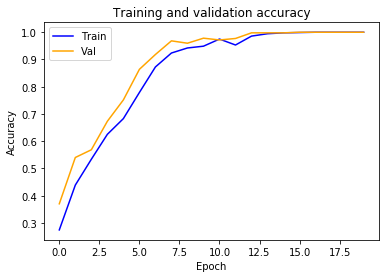

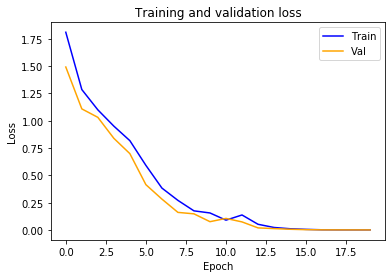

In [49]:
plot(model2_history)

It looks like there is no overfitting even out to 20 epochs since the validation (using test data) is reaching a 100% accuracy
#### This is definitely better than baseline but lets check that same image prediction that failed above with the baseline

In [50]:
# make predictions
batch_pred2 = model2.predict(im_batch) # returns a list of predictions
pred2 = batch_pred2[0] 

print("Prediction:", label_names[tf.argmax(pred2)])
print("Actual:", label_names[train_labels[img_index]])

Prediction: dandelion
Actual: dandelion


#### Success.. much better than baseline

## 1c) Try to get your flowers model working in TensorFlow.js
In the final part of the assignment, you'll export the model you build to recognize landmarks on Columbia's campus, and get it working in the browser. It's easiest to start by exporting your flowers model, and getting it working with TensorFlow.js (the starter code is build around your flowers model, so you can learn the mechanics before trying something more complex).

### Save your model

In [55]:
model2.save("my_flower_model.h5")

In [58]:
#!ls -lha

### Download it to your local machine

In [59]:
#from google.colab import files
#files.download("/content/my_model.h5")

#### Already downloaded to machine since not using Colab

### Visit notebook #2 to convert it to TensorFlow.js format
Follow the instructions there to prepare a webpage to run your flowers model in the browser. Once you have that working, continue with the rest of this assignment.

### The flowers model is working in the browser. See below website:
http://muftayebaly.com/apps/deepflowers/

## 1d) Transfer learning

In this part of the assignment, you'll use transfer learning to take advantage of a large pretrained model. It is not necesary to deploy this part in the browser.


References:
* https://www.tensorflow.org/beta/tutorials/images/transfer_learning

In [67]:
## TODO: your code here
# Choose a pretrained model, and import the application
# See https://keras.io/applications/ for a few choices
# When you import the model, you will want to remove the 
# final dense layer that performs classification (include_top=False)
# you will also want to import weights from ImageNet,
# and you will want to specify the input shape to match your images. 

base_model = tf.keras.applications.xception.Xception(include_top=False, weights='imagenet', input_tensor=None, input_shape=(IMG_SIZE, IMG_SIZE, 3)) # fix me. base_model = tf.keras.applications...

In [68]:
# A hack to show you the output shape of the model
for image_batch, label_batch in train_ds.take(1):
   pass
  
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 2048)


In [69]:
# do not update the pretrained weights during training
# (we won't use finetuning here)
base_model.trainable = False 

In [70]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 95, 95, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 95, 95, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 95, 95, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [71]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

In [72]:
# build a new model reusing the pretrained base
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [73]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [74]:
model.fit(train_ds, validation_data=test_ds, epochs=5)

Epoch 1/5
29/29 [==============================] - 531s 18s/step - loss: 1.3181 - accuracy: 0.5163 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
29/29 [==============================] - 533s 18s/step - loss: 0.9014 - accuracy: 0.7636 - val_loss: 1.0244 - val_accuracy: 0.5926
Epoch 3/5
29/29 [==============================] - 577s 20s/step - loss: 0.7128 - accuracy: 0.8290 - val_loss: 0.8671 - val_accuracy: 0.6667
Epoch 4/5
29/29 [==============================] - 522s 18s/step - loss: 0.6265 - accuracy: 0.8410 - val_loss: 0.8973 - val_accuracy: 0.6699
Epoch 5/5
29/29 [==============================] - 529s 18s/step - loss: 0.5528 - accuracy: 0.8584 - val_loss: 0.9788 - val_accuracy: 0.6536


## 2a) Recognize landmarks on Columbia's campus

In this part of the assignment, you will train a model to recognize landmarks (famous places, like the [Alma Mater sculpture](https://en.wikipedia.org/wiki/Alma_Mater_(New_York_sculpture), or Butler library) on Columbia’s campus. Instead of tf.data, you will gain experience with the higher level Keras utilties. You will also experiment with data augmentation to increase the effective size of your dataset.

Starter code is not provided for this part of the assignment. You should base your work off the following Keras notebook, which works identically in TF2 (the only thing you'll need to change is the imports, an example of correct imports is given below).

* https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb

Here are steps you should complete.

1. Collect a dataset of at least three landmarks. Your dataset should include at least 50 images of each landmark in train, and 50 in validation (using more images is fine). Randomly shuffle your data to create these splits. You do not need to use a separate test set in this assignment.

 You will need to upload your dataset to Colab in order to train a model. To do so, you can either upload it using the file browser (slow and tedious, you'll need to repeat that if your runtime is reset), or (better) you can upload your dataset to Google Drive, then mount your drive as a filesystem in Colab (View -> Table of contents -> Code snippets -> search for "drive"). This will enable you to access the contents of your drive with commands like `!ls /gdrive`. As a another option, you could upload your dataset to a cloud provider or your Columbia account, then download it similarly to flowers at the top of this notebook.
 
1. Write a model to classify your data. Try to train a small model in terms of the number of parameters (you do not need to use transfer learning). 

1. Show predictions on several images.

1. Use data augmentation, see if this helps to improve accuracy.

1. Produce plots of accuracy / loss as a function of epochs. Determine the right place to stop training without overfitting.

When you have a reasonably accurate model, proceed to the next step. There are no guidelines for accuracy, try to build something you feel works well, given the small amount of data you have.

In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [55]:
# Example code showing the correct imports

# Example code:
# You should use the keras preprocessing utilities here instead of tf.data
# Here's an example of how to use them with the flowers dataset
# You will need to add data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        data_root,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32)

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

###
# TODO: your code for 2a here.
###


Found 3670 images belonging to 5 classes.
data batch shape: (32, 192, 192, 3)
labels batch shape: (32, 5)


In [56]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 300
SHUFFLE_SIZE = 1000

In [57]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='http://muftayebaly.com/dropbox/ColumbiaLandmarks.zip',
                                         fname='ColumbiaLandmarks.zip', extract=True)

1179688960/1179680798 [==============================] - 89s 0us/step


In [58]:
data_root = str(pathlib.Path(data_root_orig).parents[0])+'/ColumbiaLandmarks'
print(data_root)

/Users/Muf/.keras/datasets/ColumbiaLandmarks


#### Split into train and test folders randomly
Using modified code from github as a starter

In [59]:
import math
import os
import random
import shutil
from collections import defaultdict
from os.path import abspath, join, basename, exists


def get_containing_folder_name(path):
    #dirname has inconsistent behavior when path has a trailing slash
    full_containing_path = abspath(join(path, os.pardir))
    return basename(full_containing_path)

def split_dataset_train_test(main_dir, train_dir, test_dir, test_percent,
                                           stratify=True, seed=None):
    prev_state = None
    if seed:
        prev_state = random.getstate()
        random.seed(seed)
    
    #Clean train and test directories
    #if train_dir.count('/') > 1:
    #    shutil.rmtree(train_dir, ignore_errors=False)
    #    os.makedirs(train_dir)
    #    print("Train directory: " + train_dir)
    #else:
    #    print("Did not delete train dir: " + train_dir)
    
    #if test_dir.count('/') > 1:
    #    shutil.rmtree(test_dir, ignore_errors=False)
    #    os.makedirs(test_dir)
    #    print("Test directory: " + test_dir)
    #else:
    #    print("Did not delete test dir: " + test_dir)

    files_per_class = defaultdict(list)

    for subdir, dirs, files in os.walk(main_dir):
        category_name = basename(subdir)

        #Don't create a subdirectory for the root directories
        if category_name in map(basename, [main_dir, train_dir, test_dir]):
            continue

        # filtered past top-level dirs, now we're in a category dir
        files_per_class[category_name].extend([join(abspath(subdir), file) for file in files])

    # keep track of train/validation split for each category
    split_per_category = defaultdict(lambda: defaultdict(int))
    # create train/validation directories for each class
    class_directories_by_type = defaultdict(lambda: defaultdict(str))
    for category in files_per_class.keys():
        training_data_category_dir = join(train_dir, category)
        if not exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)
        class_directories_by_type['train'][category] = training_data_category_dir

        testing_data_category_dir = join(test_dir, category)
        if not exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)
        class_directories_by_type['validation'][category] = testing_data_category_dir

    if stratify:
        for category, files in files_per_class.items():

            random.shuffle(files)
            last_index = math.ceil(len(files) * test_percent)
            # print('files upto index {} to val'.format(last_index))
            # print('category {} train/validation: {}/{}'.format(category, len(files[:last_index]),
            #                                                    len(files[last_index:])))
            for file in files[:last_index]:
                testing_data_category_dir = class_directories_by_type['validation'][category]
                # print('moving {} to {}'.format(file, join(testing_data_category_dir, basename(file))))
                shutil.move(file, join(testing_data_category_dir, basename(file)))
                split_per_category['validation'][category] += 1
            for file in files[last_index:]:
                training_data_category_dir = class_directories_by_type['train'][category]
                # print('moving {} to {}'.format(file, join(training_data_category_dir, basename(file))))
                shutil.move(file, join(training_data_category_dir, basename(file)))
                split_per_category['train'][category] += 1

    else:  # not stratified, move a fraction of all files to validation
        files = []
        for file_list in files_per_class.values():
            files.extend(file_list)

        random.shuffle(files)
        last_index = math.ceil(len(files) * test_percent)
        for file in files[:last_index]:
            category = get_containing_folder_name(file)
            directory = class_directories_by_type['validation'][category]
            shutil.move(file, join(directory, basename(file)))
            split_per_category['validation'][category] += 1
        for file in files[last_index:]:
            category = get_containing_folder_name(file)
            directory = class_directories_by_type['train'][category]
            shutil.move(file, join(directory, basename(file)))
            split_per_category['train'][category] += 1

    if seed:
        random.setstate(prev_state)
    return split_per_category

In [60]:
#Set directory paths
main_dir = str(data_root)
train_dir = str(data_root)+"/train"
test_dir = str(data_root)+"/test"

#Create the train and test directories
os.makedirs(train_dir)
os.makedirs(test_dir)

#Split the dataset into train and test folders
split_files_dict = split_dataset_train_test(main_dir, train_dir, test_dir, 0.5)

In [61]:
split_files_dict

defaultdict(<function __main__.split_dataset_train_test.<locals>.<lambda>()>,
            {'validation': defaultdict(int,
                         {'butler_library': 75,
                          'the_curl': 50,
                          'whispering_bench': 51,
                          'le_marteleur': 51}),
             'train': defaultdict(int,
                         {'butler_library': 75,
                          'the_curl': 50,
                          'whispering_bench': 50,
                          'le_marteleur': 50})})

In [26]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_augment = ImageDataGenerator(rescale=1./255, 
                                           brightness_range=[0.7,1.5], 
                                           zoom_range=0.2, 
                                           rotation_range=20)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True,
        class_mode="binary")
train_gen_aug = train_datagen_augment.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True,
        class_mode="binary")

validation_gen = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True,
        class_mode="binary")

print("Show data shapes sample")
for data_batch, labels_batch in train_gen:
    print('train data batch shape:', data_batch.shape)
    print('train labels batch shape:', labels_batch.shape)
    break


Found 224 images belonging to 4 classes.
Found 224 images belonging to 4 classes.
Found 226 images belonging to 4 classes.
Show data shapes sample
train data batch shape: (32, 300, 300, 3)
train labels batch shape: (32,)


In [27]:
landmark_classes = {y:x for x,y in train_gen.class_indices.items()}
print(landmark_classes)

{0: 'butler_library', 1: 'le_marteleur', 2: 'the_curl', 3: 'whispering_bench'}


In [28]:
print(landmark_classes[labels_batch[6]])

le_marteleur


In [30]:
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3), padding="same"))
model3.add(layers.MaxPooling2D(pool_size=(2,2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model3.add(layers.MaxPooling2D(pool_size=(2,2)))
model3.add(layers.Conv2D(96, (3, 3), activation='relu', padding="same"))
model3.add(layers.MaxPooling2D(pool_size=(2,2)))
model3.add(layers.Flatten())
model3.add(layers.Dense(32, activation='relu'))
model3.add(layers.Dense(4, activation='softmax'))

In [31]:
model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model3_history = model3.fit_generator(
        train_gen,
        steps_per_epoch=29,
        epochs=13,
        shuffle=True,
        validation_data=validation_gen)

Epoch 1/13
29/29 [==============================] - 372s 13s/step - loss: 1.7966 - accuracy: 0.5846 - val_loss: 0.3749 - val_accuracy: 0.8444
Epoch 2/13
29/29 [==============================] - 379s 13s/step - loss: 0.1129 - accuracy: 0.9605 - val_loss: 0.0250 - val_accuracy: 0.9956
Epoch 3/13
29/29 [==============================] - 399s 14s/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0228 - val_accuracy: 0.9956
Epoch 4/13
29/29 [==============================] - 509s 18s/step - loss: 3.2239e-05 - accuracy: 1.0000 - val_loss: 0.0229 - val_accuracy: 0.9956
Epoch 5/13
29/29 [==============================] - 557s 19s/step - loss: 2.1294e-05 - accuracy: 1.0000 - val_loss: 0.0239 - val_accuracy: 0.9956
Epoch 6/13
29/29 [==============================] - 422s 15s/step - loss: 2.3202e-05 - accuracy: 1.0000 - val_loss: 0.0282 - val_accuracy: 0.9956
Epoch 7/13
29/29 [==============================] - 13974s 482s/step - loss: 1.3891e-05 - accuracy: 1.0000 - val_loss: 0.0293 - val_accu

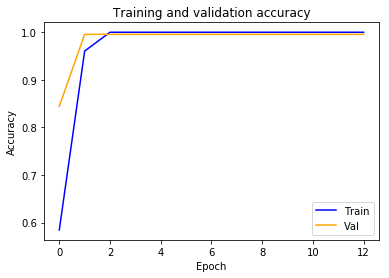

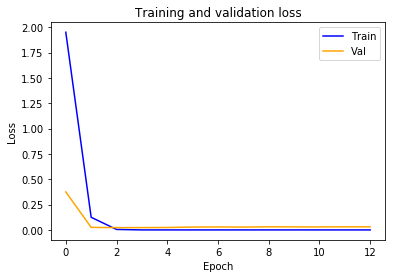

In [32]:
plot(model3_history)

In [34]:
#model3.save('landmark_overfit.h5')

Since it appears I am overfitting, I am going to create a smaller parameter model (as mentioned in the problem description) and use less epochs

In [33]:
model4 = models.Sequential()
model4.add(layers.Conv2D(16, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3), padding="same"))
model4.add(layers.MaxPooling2D(pool_size=(2,2)))
model4.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model4.add(layers.MaxPooling2D(pool_size=(2,2)))
model4.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model4.add(layers.MaxPooling2D(pool_size=(2,2)))
model4.add(layers.Flatten())
model4.add(layers.Dense(32, activation='relu'))
model4.add(layers.Dense(4, activation='softmax'))

In [34]:
model4.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model4_history = model4.fit_generator(
        train_gen,
        steps_per_epoch=29,
        epochs=4,
        shuffle=True,
        validation_data=validation_gen)

Epoch 1/4
29/29 [==============================] - 286s 10s/step - loss: 0.8170 - accuracy: 0.7360 - val_loss: 0.1738 - val_accuracy: 0.9513
Epoch 2/4
29/29 [==============================] - 251s 9s/step - loss: 0.0149 - accuracy: 0.9978 - val_loss: 0.0506 - val_accuracy: 0.9823
Epoch 3/4
29/29 [==============================] - 262s 9s/step - loss: 9.6968e-05 - accuracy: 1.0000 - val_loss: 0.0558 - val_accuracy: 0.9779
Epoch 4/4
29/29 [==============================] - 269s 9s/step - loss: 4.7004e-05 - accuracy: 1.0000 - val_loss: 0.0573 - val_accuracy: 0.9779


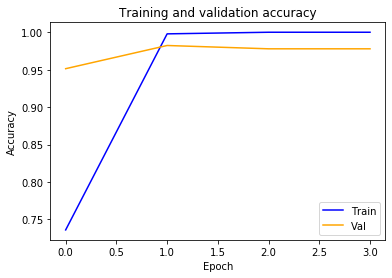

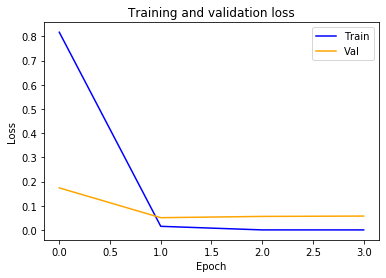

In [35]:
plot(model4_history)

### Now we make some predictions on the test data

In [42]:
#lets just check the first batch in our test data since there are 32 imgs
for test_batch1, test_labels1 in validation_gen:
    print('test batch shape:', test_batch1.shape)
    print('test labels batch shape:', test_labels1.shape)
    break


test batch shape: (32, 300, 300, 3)
test labels batch shape: (32,)


In [43]:
landmarkPredicts = model4.predict(test_batch1)

Prediction: butler_library  
%: 0.9999999

Actual:



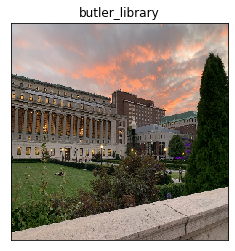

In [70]:
theMaxClass = tf.keras.backend.eval(tf.argmax(landmarkPredicts[3]))
print("Prediction:", landmark_classes[theMaxClass], " \n%:", landmarkPredicts[3][theMaxClass])
print("\nActual:")
thislabel = landmark_classes[test_labels1[3]]
show(test_batch1[3], thislabel)

Prediction: the_curl  
%: 1.0

Actual:



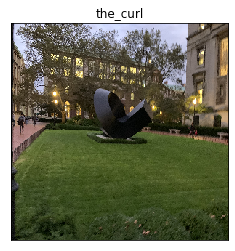

In [71]:
theMaxClass = tf.keras.backend.eval(tf.argmax(landmarkPredicts[1]))
print("Prediction:", landmark_classes[theMaxClass], " \n%:", landmarkPredicts[1][theMaxClass])
print("\nActual:")
thislabel = landmark_classes[test_labels1[1]]
show(test_batch1[1], thislabel)

Prediction: whispering_bench  
%: 0.99998665

Actual:



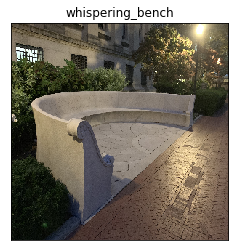

In [72]:
theMaxClass = tf.keras.backend.eval(tf.argmax(landmarkPredicts[9]))
print("Prediction:", landmark_classes[theMaxClass], " \n%:", landmarkPredicts[9][theMaxClass])
print("\nActual:")
thislabel = landmark_classes[test_labels1[9]]
show(test_batch1[9], thislabel)

### The model is predicting really well, but lets add some data augmentation to prevent overfitting

In [74]:
#model4.save("landmark_no_augment.h5")

In [75]:
model4_history2 = model4.fit_generator(
        train_gen_aug,
        steps_per_epoch=29,
        epochs=4,
        shuffle=True,
        validation_data=validation_gen)

Epoch 1/4
29/29 [==============================] - 316s 11s/step - loss: 0.3145 - accuracy: 0.9300 - val_loss: 0.0493 - val_accuracy: 0.9912
Epoch 2/4
29/29 [==============================] - 284s 10s/step - loss: 0.0488 - accuracy: 0.9860 - val_loss: 0.0139 - val_accuracy: 0.9867
Epoch 3/4
29/29 [==============================] - 287s 10s/step - loss: 0.0295 - accuracy: 0.9881 - val_loss: 0.0440 - val_accuracy: 0.9867
Epoch 4/4
29/29 [==============================] - 281s 10s/step - loss: 0.0082 - accuracy: 0.9968 - val_loss: 0.0154 - val_accuracy: 0.9912


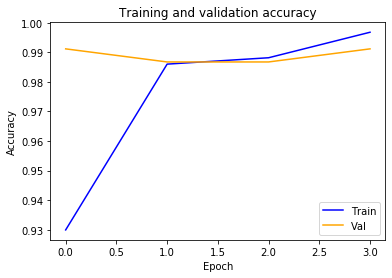

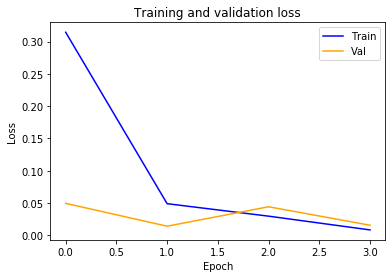

In [77]:
plot(model4_history2)

### Now lets test a few more predictions

In [83]:
landmarkPredicts2 = model4.predict(test_batch1)

Prediction: the_curl  
%: 1.0

Actual:



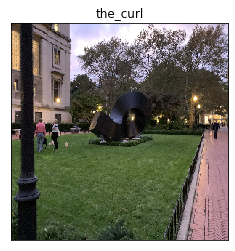

In [84]:
theMaxClass = tf.keras.backend.eval(tf.argmax(landmarkPredicts2[11]))
print("Prediction:", landmark_classes[theMaxClass], " \n%:", landmarkPredicts2[11][theMaxClass])
print("\nActual:")
thislabel = landmark_classes[test_labels1[11]]
show(test_batch1[11], thislabel)

Prediction: le_marteleur  
%: 1.0

Actual:



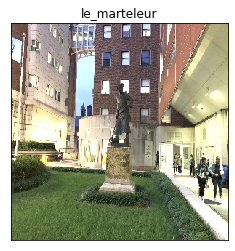

In [85]:
theMaxClass = tf.keras.backend.eval(tf.argmax(landmarkPredicts2[17]))
print("Prediction:", landmark_classes[theMaxClass], " \n%:", landmarkPredicts2[17][theMaxClass])
print("\nActual:")
thislabel = landmark_classes[test_labels1[17]]
show(test_batch1[17], thislabel)

Prediction: butler_library  
%: 1.0

Actual:



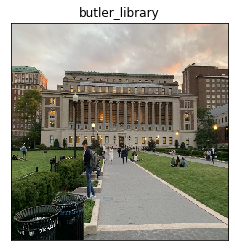

In [89]:
theMaxClass = tf.keras.backend.eval(tf.argmax(landmarkPredicts2[25]))
print("Prediction:", landmark_classes[theMaxClass], " \n%:", landmarkPredicts2[25][theMaxClass])
print("\nActual:")
thislabel = landmark_classes[test_labels1[25]]
show(test_batch1[25], thislabel)

Full prediction list

In [98]:
for i in range(32):
    theMaxClass = tf.keras.backend.eval(tf.argmax(landmarkPredicts2[i]))
    print(i, "\tActual:", landmark_classes[test_labels1[i]].ljust(26), 
          "Prediction:", landmark_classes[theMaxClass].ljust(26), "%:", landmarkPredicts2[i][theMaxClass])

0 	Actual: whispering_bench           Prediction: whispering_bench           %: 1.0
1 	Actual: the_curl                   Prediction: the_curl                   %: 0.999977
2 	Actual: the_curl                   Prediction: the_curl                   %: 0.99750715
3 	Actual: butler_library             Prediction: butler_library             %: 1.0
4 	Actual: butler_library             Prediction: butler_library             %: 1.0
5 	Actual: butler_library             Prediction: butler_library             %: 1.0
6 	Actual: butler_library             Prediction: butler_library             %: 1.0
7 	Actual: whispering_bench           Prediction: whispering_bench           %: 0.99999964
8 	Actual: butler_library             Prediction: butler_library             %: 1.0
9 	Actual: whispering_bench           Prediction: whispering_bench           %: 1.0
10 	Actual: whispering_bench           Prediction: whispering_bench           %: 0.9999994
11 	Actual: the_curl                   Prediction:

### Looks like we have a pretty good trained model so now lets save the model and get it in the browser for more interactive use

In [95]:
model4.save("landmark_with_augment.h5")

## 2b) Donate your dataset (optional)
We will use the dataset collected by the class later in the semester.

Requirements:

* Please do not include any images with people in the foreground.
* Only include images you have taken yourself and that you are comfortable sharing publicly under a [CCO](https://creativecommons.org/share-your-work/public-domain/cc0/) license (TLDR, public domain).

Link to upload a zip is on CourseWorks. Your file should be in the same format as the flowers dataset (the directory names gives the label for each image).



### Dataset found at the url below:
http://muftayebaly.com/dropbox/ColumbiaLandmarks.zip

## 3) Run your model in the browser
Save and download your model, and head to notebook two again. After you've finished creating a webpage, upload it to GitHub pages or your Columbia account, list the URL here, and submit your assignment. You may not need to make many changes to the starter code, but pay attention to the preprocessing, number of output classes, image size, etc.

http://muftayebaly.com/apps/deepcolumbialandmarks

Tested with my own images as well as images from the web and it works great!